# Solving the Krusell-Smith model in sequence space
In this notebook we show how to
1. [Set up a heterogeneous-agent block](#1-hetblock)
2. [Solve for the steady state](#2-calibration)
3. [Compute the Jacobian](#3-jacobian)
4. [Compute linearized impulse responses](#4-linear)
5. [Estimate shock parameters](#5-estimate)
6. [Compute nonlinear impulse responses](#6-nonlinear)

This notebook accompanies work in progress by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## Model description
For a detailed description of the model, please see the slides or the paper. As a quick reminder, it can be written in sequence space as

$$
\textbf{H}_t(\textbf{U}, Z) \equiv 
\begin{pmatrix}
%Y_t - Z_t K_t^\alpha L^{1-\alpha}
%\\
r_t + \delta - \alpha Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha-1} 
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t}\right)^{\alpha}
\\
L_t - \sum_e \pi(e) e l
\\
\mathcal{K}_t(\{r_s, w_s\}) - K_t
\end{pmatrix}
= \begin{pmatrix}  0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the (aggregate) endogenous variables are $\textbf{U} = (K, L, r, w)$ and the only exogenous variable is $Z$. Let's normalize $\sum_e \pi(e) el = 1$ without loss of generality.

The capital function $\mathcal{K}$ follows from the household block characterized by a Bellman equation

$$
\begin{align}
V_t(e, k_{-}) = \max_{c, k} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \sum_{e'}V_{t+1}(e', k) \mathcal{P}(e, e') \right\}
\\
c + k &= (1 + r_t)k_{-} + w e l 
\\
k &\geq 0
\end{align}
$$

We can represent this model as a simple directed acyclical graph:

![Directed Acyclical Graph](figures/ks_dag.png) 

and write it as

$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0.
$$

## 0 Import packages
The first five are standard python packages, the rest contain code we wrote for this project. 

In [1]:
import numpy as np
from numba import njit
import scipy.optimize as opt
import scipy.linalg as linalg
import matplotlib.pyplot as plt

import utils
import het_block as het
import simple_block as sim
from simple_block import simple
import jacobian as jac
import estimation as est
import krusell_smith as ks

<a id="1-hetblock"></a>

## 1 Set up heterogeneous-agent block
The main task here is to write a **backward iteration function** that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration. For the standard income fluctuation problem we're dealing with here, the endogenous gridpoint method of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice. 

We are going to use the backward iteration function to construct a `HetBlock` instance. As its name suggests, HetBlock is a general class of heterogeneous-agent blocks that comes with useful methods, such as solving for steady-state policy functions by iteration and computing Jacobians. In this notebook, we are going to cover all of these.

In [2]:
def backward_iterate(Va_p, Pi_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (S*A), marginal value of assets tomorrow
    Pi_p     : array (S*S), Markov matrix for skills tomorrow
    a_grid   : array (A), asset grid
    e_grid   : array (A), skill grid
    r        : scalar, ex-post interest rate
    w        : scalar, wage
    beta     : scalar, discount rate today
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (S*A), marginal value of assets today
    a  : array (S*A), asset policy today
    c  : array (S*A), consumption policy today
    """
    uc_nextgrid = (beta * Pi_p) @ Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = utils.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    utils.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

Now we're ready to initialize the HetBlock of this model. In addition to the backward iteration function, we only have to specify the transition matrix for exogenous states `exogenous`, the policy corresponding to the endogenous state(s) `policy` (currently up to maximum number of 2), and the backward variable `backward`.

In [3]:
household = het.HetBlock(backward_iterate, exogenous='Pi', policy='a', backward='Va')

<a id="2-calibration"></a>

## 2 Calibrating the steady state
Next, we calibrate the HA block in general equilibrium. The calibration exercise amounts to finding the right discount factor to hit a targeted annual interest rate conditional on all the other exogenous parameters. We use Brent's method, an efficient way to solve for a root on an interval, from the `scipy.optimize` package to do so.

Although additional efficiency gains would be possible here (for instance, by updating our initial guesses for policy and distribution along the way), we will not implement them, since they are not our focus here.

Our default values depart slightly from the canonical Krusell-Smith calibration, mainly by assuming a 7-state income process and a lower capital share. More risk increases the precautionary savings motive, while less capital limits the ability to self-insure. These changes lead to higher MPCs and less RA-like behavior.

In [4]:
def ks_ss(lb=0.98, ub=0.999, r=0.01, eis=1, delta=0.025, alpha=0.11, rho=0.966, sigma=0.5, nS=7, nA=500, amax=20):
    """Solve steady state of full GE model. Calibrate beta to hit target for interest rate."""
    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_s, Pi = utils.markov_rouwenhorst(rho=rho, sigma=sigma, N=nS)

    # solve for aggregates analitically
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * (alpha * Z / rk) ** (alpha / (1 - alpha))
    
    # initialize guess
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # solve for beta consistent with this
    beta_min = lb / (1 + r)
    beta_max = ub / (1 + r)
    beta, sol = opt.brentq(lambda bet: household.ss(Pi=Pi, a_grid=a_grid, e_grid=e_grid, r=r, w=w, beta=bet, eis=eis,
                                                    Va=Va)['A'] - K, beta_min, beta_max, full_output=True)
    if not sol.converged:
        raise ValueError('Steady-state solver did not converge.')

    # extra evaluation to report variables
    ss = household.ss(Pi=Pi, a_grid=a_grid, e_grid=e_grid, r=r, w=w, beta=beta, eis=eis, Va=Va)
    ss.update({'w': w, 'Z': Z, 'K': K, 'L': 1, 'Y': Y, 'alpha': alpha, 'delta': delta,
               'goods_mkt': Y - ss['C'] - delta * K})

    return ss

Notice the use of `household.ss` to evaluate steady-state asset demand for given inputs. This is the first HetBlock method we see in action.

Let's solve for the steady state using our default calibration, and plot the consumption policy function for all skill types  as a function of assets.

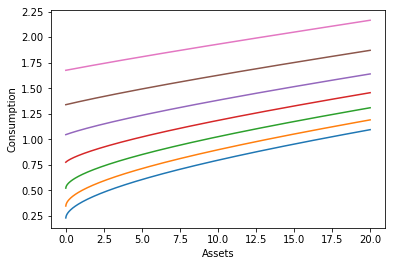

In [5]:
ss = ks_ss()
plt.plot(ss['a_grid'], ss['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()

### Speed of steady-state solution
Our backward and forward iterations use Numba, [a just-in-time compilation library](https://numba.pydata.org/numba-doc/dev/user/5minguide.html) that translates pure numerical Python to fast machine code. The first time functions are run, there is some compilation lag, similar to (but much less time-consuming than) compilation time in languages like C++, Fortran, and Julia.

Now that we have run everything once, we can time our steady-state calibration routine. An efficient steady state is not the focus of this notebook or our methods, but it is nice to see that performance is still quite good:

In [6]:
#%time ss = ks_ss()

Indeed, this simple example is so fast that increasing the number of asset gridpoints from 500 to 2000, and thus the total number of states from $7 \times 500=3500$ to $7 \times 2000 = 14000,$ increases computation time by less than a factor of four.

In [7]:
%time _ = ks.ks_ss(nA=2000)

CPU times: user 3.27 s, sys: 55.1 ms, total: 3.33 s
Wall time: 1.72 s


### Checking Walras's law
It's always useful to check whether Walras's law holds. The omitted goods market clearing condition reads as 

$$
Y_t = \mathcal{C}_t(\{r_t, w_t\}) + K_t - (1 - \delta) K_{t-1}
$$

and is reported by the `ks_ss` function above.

In [8]:
print(ss['goods_mkt'])

6.67261731979174e-10


<a id="3-jacobian"></a>

## 3 Jacobians
Jacobians are the key concept to solve and to estimate models in sequence space. Each model block has its own Jacobians, which can be combined via the chain rule into Jacobians for the complete model. A Jacobian in a $T$-dimensional (truncated) sequence space is a $T \times T$ matrix of the form

$$
\frac{d Y}{d X} = 
\begin{pmatrix}
\frac{d Y_0}{d X_0} & \frac{d Y_0}{d X_1} & \dots & \frac{d Y_0}{d X_T} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d Y_T}{d X_0} & \frac{d Y_T}{d X_1} & \dots & \frac{d Y_T}{d X_T}
\end{pmatrix}
$$

evaluated at the steady state.

### 3.1 Simple blocks
To build intuition, let's start with the firm block. In our code, simple blocks are specified as regular Python functions  endowed with the decorator ``@simple``. In the body of the function, we directly implement the corresponding equilibrium conditions. The decorator turns the function into an instance of ``SimpleBlock``, a simple class with methods to evaluate itself in steady state and along a transition path. Notice the use of K(-1) to denote 1-period lag, similarly to Dynare. In general, one can write (-s) and (+s) to denote s-period lags and leads. 

In [9]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

Let's take a look at the Jacobian $dY/dX$, which the `sim.all_Js` function computes numerically via symmetric differencing.

`sim.all_Js` reports the Jacobians it calculates as a nested Python dictionary ("dict"), where the first level is the output variable $Y$ and the second level is the input variable $X$.

In [10]:
J_firm = sim.all_Js(firm, ss, T=5, shock_list=['K', 'Z'])
print(J_firm['Y']['Z'])

[[1.13424196 0.         0.         0.         0.        ]
 [0.         1.13424196 0.         0.         0.        ]
 [0.         0.         1.13424196 0.         0.        ]
 [0.         0.         0.         1.13424196 0.        ]
 [0.         0.         0.         0.         1.13424196]]


In principle, one could calculate a Jacobian between each input-output pair. In practice, it only makes sense to do so with respect to endogenous variables and shocks, hence the `shock_list` option. In this model, capital and TFP are the only inputs that will ever change.

The Jacobian is diagonal because the production function does not depend on leads or lags of productivity. Such sparsity is very common for simple blocks, and we wrote `simple_block.py` to take full advantage of it. If we leave the truncation parameter $T$ unspecified, `sim.all_Js` returns a sparse representation of the Jacobian. In addition to being more efficient, this sparse representation also allows us to eliminate truncation bias altogether.

In [11]:
J_firm_sparse = sim.all_Js(firm, ss, shock_list=['K', 'Z'])
print(J_firm_sparse['Y']['Z'])

SimpleSparse({(0, 0): 1.134})


### 3.2 HA blocks
HA blocks have more complicated Jacobians, but there's a regular structure that we can exploit to calculate them very quickly. For comprehensive coverage of our **fake news algorithm**, please see the [het-agent Jacobian notebook](het_jacobian.ipynb) as well as the paper.

The tools for dealing with Jacobians of HA blocks are in `het_block.py`. At the end of the day, we'll be able to call a single function, much like `simple_block.all_Js` above. Note that the shocked inputs are specified as a nested dict. This may look like an unnecessarily complicated formulation for now, but it pays off handsomely in richer models, since it allows us to compute Jacobians with respect to shocks that change several multidimensional inputs to the HA block.

In [12]:
J_ha = household.all_Js(ss, T=5, shock_dict={'r': {'r': 1}, 'w': {'w': 1}}, desired_outputs=['c', 'a'])
print(J_ha['C']['r'])

[[ 0.09631684 -0.68180039 -0.64132176 -0.60456829 -0.57089036]
 [ 0.09466513  0.13510328 -0.64851023 -0.61152266 -0.57746873]
 [ 0.09302746  0.13004622  0.16693806 -0.61994633 -0.58550328]
 [ 0.09139326  0.12554496  0.15988264  0.19422162 -0.59503243]
 [ 0.08977371  0.12161183  0.15351938  0.18572774  0.218063  ]]


Notice that this matrix is no longer sparse. This generally the case for HA blocks. The Bellman equation implies that policies are forward-looking, and then aggregates are also backward-looking due to persistence coming via the distribution. However, our `SimpleSparse` Jacobians from above play nicely with full matrices. For example, the regular matrix multiplication operator `@` works on any combination.   

In [13]:
print(J_ha['C']['r'] @ J_firm_sparse['r']['Z'])

[[ 0.00382363 -0.02706643 -0.02545949 -0.02400044 -0.02266347]
 [ 0.00375806  0.00536339 -0.02574486 -0.02427651 -0.02292462]
 [ 0.00369305  0.00516264  0.00662719 -0.02461092 -0.02324358]
 [ 0.00362817  0.00498394  0.0063471   0.0077103  -0.02362188]
 [ 0.00356388  0.0048278   0.00609448  0.00737311  0.00865677]]


Very similar times for the two approaches:

In [14]:
%time _ = ks.household.all_Js(ss, T=300, shock_dict={'r': {'r': 1}, 'w': {'w': 1}}, desired_outputs=['c','a'])

CPU times: user 241 ms, sys: 24.1 ms, total: 265 ms
Wall time: 236 ms


In [15]:
%time _ = het.all_Js(backward_iterate, ss, T=300, shock_dict={'r': {'r': 1}, 'w': {'w': 1}})

CPU times: user 938 ms, sys: 26.7 ms, total: 964 ms
Wall time: 803 ms


<a id="4-linear"></a>

## 4 Linearized dynamics using Jacobians
Recall that we reduced the model to a single equation $H$

$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0.
$$

to be solved for $K$ given any $Z$.

This is the composition of the household capital supply function $\mathcal{K}$ with the interest rate $r(K_{t-1}, Z_t) = \alpha Z_t K_{t-1}^{\alpha-1} - \delta$ and wage $w(K_{t-1}, Z_t) = (1-\alpha) Z_t K_{t-1}^{\alpha}$ functions.

We will obtain a linear characterization of all impulse responses in two ways. First, by duly following the notation and algebra of section 2.2. This is hands-on approach that's transparent, but error-prone in all but the simplest cases. Second, by leveraging powerful convenience functions that minimize human input requirements and the scope for error with them. Throughout this section, we'll use the steady state `ss` we've already solved for, and a 300-period truncation horizon.

### 4.1 Hands-on approach

##### Step 1: For each block, obtain Jacobians of outputs with respect to inputs
Here, we only have two blocks: the firm and household blocks. Getting these Jacobians is quite quick, even for the HA block.

In [16]:
T = 300

# firm Jacobian: r and w as functions of K and Z
J_firm = sim.all_Js(firm, ss, shock_list=['K', 'Z'])

# household Jacobian: curlyK (called 'a' for assets by J_ha) as function of r and w
J_ha = household.all_Js(ss, T=T, shock_dict={'r': {'r': 1}, 'w': {'w': 1}}, desired_outputs=['c', 'a'])

#### Step 2: Compose Jacobians along the computational graph
Here, we manually apply the chain rule to calculate the total Jacobians of household $\mathcal{K}$ with respect to $K$ and $Z$, by composing the partial Jacobians `curlyJ_ha` (which maps $r$ and $w$ to $\mathcal{K}$) and `curlyJ_firm` (which maps $K$ and $Z$ to $r$, $w$, and $Y$).

In [17]:
J_curlyK_K = J_ha['A']['r'] @ J_firm['r']['K'] + J_ha['A']['w'] @ J_firm['w']['K']
J_curlyK_Z = J_ha['A']['r'] @ J_firm['r']['Z'] + J_ha['A']['w'] @ J_firm['w']['Z']

Now, we will combine `J_curlyK_K` and `J_curlyK_Z` with the firm Jacobians to get a single nested dict with the total Jacobians of everything with respect to $K$ and $Z$:

In [18]:
J = {**J_firm, 'curlyK': {'K' : J_curlyK_K, 'Z' : J_curlyK_Z}}

#### Step 3: Invert $H_K$ to obtain impulse response $dK=-H_K^{-1}H_ZdZ$
Now we need to get the Jacobians of our equation $H(K,Z)$, which fully characterizes equilibrium, with respect to $K$ and $Z$. Once we have these, the implicit function theorem gives us the endogenous capital $dK=-H_K^{-1}H_ZdZ$ response to any exogenous shock $dZ$.

Recall that $H$ equals household capital supply $\mathcal{K}$ minus firm capital $K$, so that we can get the Jacobians almost immediately from what we have already calculated.

In [19]:
H_K = J['curlyK']['K'] - np.eye(T)
H_Z = J['curlyK']['Z']

We define $G_K \equiv -H_K^{-1}H_Z$ to be the matrix mapping from any $dZ$ to the corresponding $dK$:

In [20]:
G = {'K': -np.linalg.solve(H_K, H_Z)} # H_K^(-1)H_Z

#### Step 4: Get all other impulses
In `J`, we have Jacobians of $r,w,Y$ with respect to both $Z$ and $K$. If there is a shock to $Z$, we can decompose the change in $r,w,Y$ into a "direct" effect from $dZ$ and an "indirect" effect from the induced change $dK$.

We apply the chain rule to the latter to get matrices $G_r, G_w, G_Y$ mapping any $dZ$ to the corresponding $dr,dw,dY$:

In [21]:
G['r'] = J['r']['Z'] + J['r']['K'] @ G['K']
G['w'] = J['w']['Z'] + J['w']['K'] @ G['K']
G['Y'] = J['Y']['Z'] + J['Y']['K'] @ G['K']

The `G` dict characterizes the full linearized dynamics of aggregate variables $K, r, w, Y$ in response to *any* perturbation to $Z$.

If we want the linearized dynamics of other variables, e.g. consumption, all we need is to get get the Jacobian from the block in which these are calculated, and then compose it with the `G` of its inputs. It turns out that consumption was already reported in `J_ha`, so we just need to write:

In [22]:
G['C'] = J_ha['C']['r'] @ G['r'] + J_ha['C']['w'] @ G['w']

If we wanted to trace the evolution of the household distribution or policy functions for a particular shock, then we could feed in the results to `household_td`, defined below.

### 4.2 Convenient approach

These steps can be automatized for the entire class of SHADE models. A SHADE model is characterized by its blocks, exogenous shocks, unknowns, and targets. In addition, we need to know the steady state around which to linearize as well as the truncation horizon.

If we define a market clearing block that returns the target (asset market clearing), we can get the general equilibrium Jacobian `G` by a single function call. (Note that the Jacobian of the HA block still has to be precomputed).

In [23]:
@simple
def mkt_clearing(K, A):
    asset_mkt = K - A
    return asset_mkt

In [24]:
G2 = jac.get_G(block_list=[firm, mkt_clearing, J_ha], exogenous=['Z'], unknowns=['K'], targets=['asset_mkt'], T=T, ss=ss)

Under the hood, `jac.get_G` does the following steps:
 - sorts the blocks in a right order (based on their inputs and outputs) to form a DAG
 - computes the partial Jacobians $\mathcal{J}^{o,i}$ of simple blocks (if their Jacobian is not supplied already), it does so only with respect to the inputs that actually change: unknowns, exogenous shocks, outputs of earlier blocks
 - forward accumulates partial Jacobians $\mathcal{J}^{o,i}$ to form the total Jacobians $\mathbf{J}^{o,i}$
 - packs $\mathbf{J}^{o,i}$ to form $\mathbf{H_U}$ and $\mathbf{H_Z}$
 - solves for the GE Jacobians for unknowns $G = \mathbf{H_U}^{-1}\mathbf{H_Z}$
 - forward accumulates GE Jacobians for other endogenous variables
 
Let's verify that the two give the same answer (up to machine precision).

In [25]:
np.allclose(G2['Y']['Z'], G['Y'])

True

### 4.2 Results
What do the impulse responses in this model look like? The beauty of our method is that, now that we have the `G`, we can compute impulse responses to any shock almost instantaneously -- it's just matrix multiplication!

Let's first consider shocks to $Z$ with different persistences, all normalized so that they have a 1% initial impact, and plot the interest rate response to each.

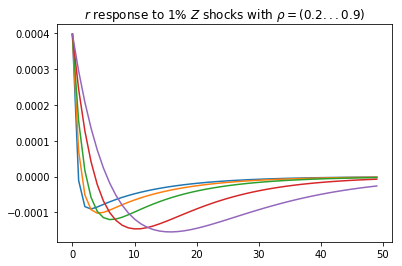

In [26]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
dZ = 0.01*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G['r'] @ dZ
plt.plot(dr[:50, :])
plt.title(r'$r$ response to 1% $Z$ shocks with $\rho=(0.2 ... 0.9)$')
plt.show()

Now let's consider 10,000 different values of rho, for which we can still calculate all $r$ impulse responses almost instantaneously.

In [27]:
rhos = np.linspace(0.1, 0.9, 10000)
dZ = 0.01*rhos**(np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
%time dr = G['r'] @ dZ

CPU times: user 62.8 ms, sys: 18.5 ms, total: 81.3 ms
Wall time: 41.3 ms


The time taken here differs from run to run, but in the current run (like all runs on a personal laptop) it takes 60 milliseconds of "wall time" to compute 10,000 impulse responses means that each impulse response takes less than **6 microseconds**. "CPU time" is slightly higher because mild parallelization on two cores is used by the built-in matrix multiplication implementation. By contrast, typical impulse response calculations in heterogeneous agent models in the literature take at least a minute, so this method is more than **10 million** times faster as a way of calculating individual impulse responses.

Although this may seem like an extreme example, repeated calculations of this form are quite useful in the most computationally demanding applications, like estimation (as we will see later).

Another important feature of our sequence space methodology is that it is easy to calculate the response to shocks that are difficult to cast into simple form, like news shocks.

For example, calculating the response to a news shock where $Z$ is expected to increase at a specific period in the future is trivial -- in fact, that's exactly what the columns of the $G$ matrix are. Below we plot the capital responses to news shocks of $Z$ increases at periods 5, 10, 15, 20, and 25.

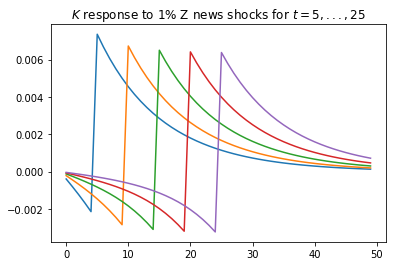

In [28]:
dZ = 0.01*(np.arange(T)[:, np.newaxis] == np.array([5, 10, 15, 20, 25]))
dK = G['K'] @ dZ
plt.plot(dK[:50])
plt.title('$K$ response to 1% Z news shocks for $t=5,...,25$')
plt.show()

<a id="5-estimate"></a>

## 5 Estimation

The roadmap for estimation is as follows 
 - impulse responses $\implies$ second moments
 - second moments $\implies$ log-likelihood
 
In this notebook, we will simply use simulated data to show that the loglikelihood peaks close to the true value of the estimated parameter, the standard deviation of TFP shocks. 

### 5.1 Second moments 
Thanks to certainty equivalence, linear impulse responses can be interpreted as the $MA(\infty)$ representation of the model. Then all we need is the second moments of the shocks to fully characterize the second moments of endogenous outcomes. This computation can be done in a highly efficient way, without any need for simulation.

For concreteness, let's suppose that the TFP shocks $dZ$ in the Krusell-Smith model have a persistent and transitory component.

$$
\begin{align*}
dZ_t &= dZ^1_t + d Z_t^2
\\
dZ_t^1 &= \rho d Z_{t-1}^1 + \epsilon^1_t
\\
d Z_t^2 &= \epsilon^2_t
\end{align*}
$$

where $\epsilon^1$ and $\epsilon^2$ are i.i.d. normal with mean zero and with variance $\sigma^2_1$ and $\sigma^2_2$. 

Let $m^{x, 1}$ and $m^{x,2}$ denote the (truncated) impulse responses of variable $X$ to these two structural shocks. Thus we have an $MA(T-1)$ representation:

$$
X_t = \sum_{z=1}^{2} \sum_{s=0}^{T-1} m^{x,z}_s \epsilon_{t-s}^z 
$$

It follows that covariances between outcomes $Y$ and $X$ take the form

$$
\text{Cov}(Y_t, X_{t+l})= \sum_{z=1}^{2} \sigma_z^2 \sum_{s=0}^{T-1} m_s^{x,z} m_{s+l}^{y,z} \tag{Cov}
$$

#### Step 1. Stacked impulse responses

Given the $G$ matrix we calculated in section 4. This is just a matter of matrix multiplication:

In [29]:
rho = 0.9
sigma_persist = 0.01
sigma_trans = 0.04

dZ1 = rho**(np.arange(T))
dY1, dC1, dK1 = G['Y'] @ dZ1, G['C'] @ dZ1, G['K'] @ dZ1
dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)

dZ2 = np.arange(T) == 0
dY2, dC2, dK2 = G['Y'] @ dZ2, G['C'] @ dZ2, G['K'] @ dZ2
dX2 = np.stack([dZ2, dY2, dC2, dK2], axis=1)

Let's stack all these to make a $T\times 4 \times 2$ array giving all impulse responses of the four outcomes to the two shocks:

In [30]:
dX = np.stack([dX1, dX2], axis=2)
dX.shape

(300, 4, 2)

#### Step 2. Convolution via Fast Fourier Transform

The covariance formula above is implemented efficiently as a general function.

In [31]:
sigmas = np.array([sigma_persist, sigma_trans])
%time Sigma = est.all_covariances(dX, sigmas, T)

CPU times: user 6.1 ms, sys: 1.24 ms, total: 7.34 ms
Wall time: 3.6 ms


#### Visualizing correlations

Let's turn the covariance matrix `Sigma` into a correlation matrix, by normalizing it with the standard deviation of each series:

In [32]:
sd = np.sqrt(np.diag(Sigma[0, ...]))
correl = (Sigma/sd)/(sd[:, np.newaxis])

Finally, let's plot $\text{corr}(dZ_t,dZ_{t+l})$, $\text{corr}(dZ_t,dY_{t+l})$, $\text{corr}(dZ_t,dC_{t+l})$, and $\text{corr}(dZ_t,dK_{t+l})$, for $l$ from $-50$ through $50$: the correlations of all series, at various lags, with the driving productivity process.

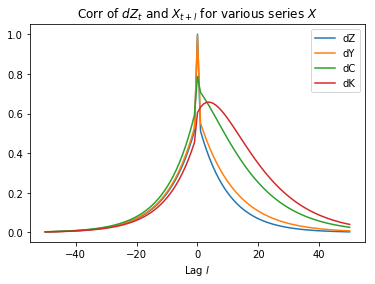

In [33]:
ls = np.arange(-50, 51)
corrs_l_positive = correl[:51, 0, :]
corrs_l_negative = correl[50:0:-1, :, 0]
corrs_combined = np.concatenate([corrs_l_negative, corrs_l_positive])

plt.plot(ls, corrs_combined[:, 0], label='dZ')
plt.plot(ls, corrs_combined[:, 1], label='dY')
plt.plot(ls, corrs_combined[:, 2], label='dC')
plt.plot(ls, corrs_combined[:, 3], label='dK')
plt.legend()
plt.title(r'Corr of $dZ_t$ and $X_{t+l}$ for various series $X$')
plt.xlabel(r'Lag $l$')
plt.show()

Here we can see many features of the solution. First, $dY$ is extremely similar to $dZ$, except that it has a greater lagged response due to capital accumulation. Both $dZ$ and $dY$ have a large peak at $l=0$ corresponding to the transitory shock. $dC$ and $dK$, on the other hand, are both much smoother and tend to lag $dZ$, especially $dK$.

### 5.2 Log-likelihood

The key observation is that assuming the means of all series are zero (which is often imposed through some kind of preliminary demeaning or detrending procedure on the data), and that the shocks are multivariate normal, all we really need to evaluate the log-likelihood is the covariance matrix $\mathbf{V}_w$ of the vector of observations $\mathbf{w}$ used for estimation. Then we have (up to a constant):

$$
\mathcal{L} = -\frac{1}{2}\log(\det(\mathbf{V}_w)) - \frac{1}{2}\mathbf{w}'\mathbf{V}_w^{-1}\mathbf{w} \tag{log-likelihood}
$$ 

**Step 1: calculate $\mathbf{V}_w$**, here with a direct construction from the covariance function. 

In [34]:
V = est.build_full_covariance_matrix(Sigma, np.full(4, 0.01), 100) # burn-in
%time V = est.build_full_covariance_matrix(Sigma, np.full(4, 0.01), 100)
V.shape

CPU times: user 794 µs, sys: 1.17 ms, total: 1.96 ms
Wall time: 1.97 ms


(400, 400)

**Step 2: Evaluate log-likelihood formula**
on random 100 observations dor each variable.

In [35]:
w = np.random.randn(400)
%time est.log_likelihood(V, w)

CPU times: user 6.82 ms, sys: 1.57 ms, total: 8.39 ms
Wall time: 5.88 ms


-1008535.166554846

### 5.3 Putting it together: calculating the likelihood in an example
Continue to consider the shock process from section 5.1, where $dZ$ had one persistent component and one transitory component. Imagine that we do not know the persistence parameter $\rho$ of the persistent component, nor do we know the relative variances of these two shocks or the variances of the measurement errors. Given some observed data $\mathbf{w}$ with 100 observations of $dZ, dY, dC, dY$, what does the log-likelihood as a function of these parameters look like, and how do we compute it?

We write the following function.

In [36]:
def log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigmas_measure, w):
    # impulse response to persistent shock
    dZ1 = rho**(np.arange(T))
    dY1, dC1, dK1 = G['Y'] @ dZ1, G['C'] @ dZ1, G['K'] @ dZ1
    dX1 = np.stack([dZ1, dY1, dC1, dK1], axis=1)
    
    # since transitory shock does not depend on any unknown parameters,
    # except scale sigma_trans, we just reuse the dX2 already calculated earlier!
    
    # stack impulse responses together
    dX = np.stack([dX1, dX2], axis=2)
    
    # calculate all covariances
    Sigma = est.all_covariances(dX, np.array([sigma_persist, sigma_trans]), T)
    
    # build full covariance matrix for data
    V_w = est.build_full_covariance_matrix(Sigma, sigmas_measure, int(w.shape[0]/4))
    
    # calculate log-likelihood from this
    return est.log_likelihood(V_w, w)

**Simulate sample data.** Now let's simulate more realistic series $w=\{dZ, dY, dC, dK\}$, assuming the same parameters as above, to see what evaluating the log-likelihood is like. To do so, we use the variance matrix `V` calculated above. We add i.i.d. measurement errors as well to avoid degeneracy.

In [37]:
sigmas_measure = np.full(4, 0.01)
w = np.random.multivariate_normal(np.zeros(400), V)

Now let's plot the log-likelihood of $w$ as a function of the standard deviation of the persistent component (the true value of which is 0.01), given correct values for all other parameters. Note that evaluating the log-likelihood 100 times takes well below one second.

In [38]:
sigma_persist_values = np.linspace(0.005, 0.02, 100)
%time lls = np.array([log_likelihood_from_parameters(rho, sigma_persist, sigma_trans, sigmas_measure, w) for sigma_persist in sigma_persist_values])

CPU times: user 774 ms, sys: 67 ms, total: 841 ms
Wall time: 685 ms


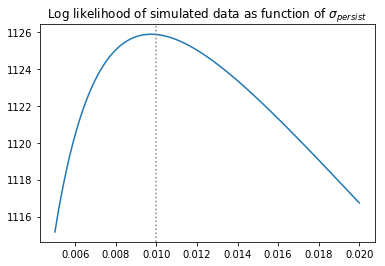

In [39]:
plt.plot(sigma_persist_values, lls)
plt.axvline(0.01, linestyle=':', color='gray')
plt.title(r'Log likelihood of simulated data as function of $\sigma_{persist}$')
plt.show()

Reassuringly, the mode is near (although not exactly at, since we're simulating a finite sample with only 100 periods) the value of $\sigma_{persist}=0.01$ with which the data was simulated!

<a id="7-nonlinear"></a>

## 7 Nonlinear dynamics
Linearized impulse responses are invariant to the sign and size of aggregate shocks by construction. Although this is not a problem for many applications, it is clearly a limitation. Here, we demonstrate that the Jacobian can also be extremely useful in solving for nonlinear dynamics.

Let us start by considering the case of an economy that starts at the steady state, and receives an unexpected shock at date 0. This is often called an "MIT shock". 

For a given shock $Z$, the solution is still characterized by the $K$ that solves $H(K,Z)=0$. Our algorithm to find this $K$, a simple variant of Newton's method, iterates on a sequence of guesses $K^j$ for the path of capital as follows:
1. starting with $j=0$, guess a path $K^0$
2. calculate $H(K^j, Z)$
3. update the guess according to $$K^{j+1} = K^j - H_K(K_{ss}, Z_{ss})^{-1} H(K^j, Z)$$
and return to step 2 for $j+1$

The only difference between this and the standard Newton's method is that we use the Jacobian $H_K$ around the steady state (which we have already calculated), rather than the Jacobian around the current guess (which is somewhat more difficult to calculate). Still, this tends to achieve extremely fast convergence.

Although iterative methods to solve for equilibrium in response to MIT shocks are quite common in the heterogeneous-agent literature, these methods generally use ad-hoc rules for updating the guess, which can be fragile and slow. In applications with no or limited heterogeneity (such as spender-saver models) where it is possible to calculate Jacobians easily, Newton's method has been used to provide faster and more robust convergence -- see, for instance, [Juillard (1996)](http://www.cepremap.fr/depot/couv_orange/co9602.pdf).

But until now, this has not been applied to heterogeneous-agent models, since the Jacobian has been too difficult to calculate. The only partial applications to date, to our knowledge, are in [Auclert and Rognlie (2018)](http://web.stanford.edu/~aauclert/computational_appendix_inequad.pdf), which uses an auxiliary model to compute an approximate Jacobian, and in [Straub (2018)](https://scholar.harvard.edu/files/straub/files/jmp_straub_jan_2.pdf), which uses interpolation to compute an approximate Jacobian. In this paper, however, we have provided a highly efficient method to compute the *exact* Jacobian around the steady state for any heterogeneous-agent model, and can thus readily apply Newton's method.

### 7.1 Algorithm
First we need functions that can evaluate the building blocks of $H(K,Z)$, the firm block and household block, nonlinearly for arbitrary inputs.

Since some of the details are slighly tedious, we relegate the function `household_td` to the module `ks.py`. This function, which performs a backward iteration to get policies and a forward iteration to update the distribution, is called by providing the steady state and then specifying the path of any input that deviates from the steady state.

By using the decorator `@simple`, we have already enabled the firm block to evaluate itself on any path by using the method `.td()`.

Combining these, it is easy to write the function $H(K,Z)$ below as `td_map`, which takes in the steady state and paths for $K$ and $Z$ and returns the asset market clearing discrepancy. It also returns, in `td`, paths for $r,w,K,Z,Y$ and household variables that are calculated along the way.

In [40]:
def td_map(ss, K, Z):
    # firm block
    out = firm.td(ss, K=K, Z=Z)

    # ha block
    td = ks.household_td(ss, r=out['r'], w=out['w'])
    td.update(out)
    td.update({'K':K, 'Z':Z})

    return td['A'] - K, td

Now we can run Newton's method, given $H_K^{-1}$. Once a path $K$ is found such that asset market clearing holds, we return the dict `td` with all paths.

In [41]:
def td_nonlinear(ss, H_K_inv, Z, tol=1E-8, maxit=30, noisy=True):
    """Compute non-linear impulse response via Newton's method."""
    # initialize guess at ss
    T = Z.shape[0]
    K = np.full(T, ss['K'])

    # iterate until convergence
    for it in range(maxit):
        asset_mkt, td = td_map(ss, K, Z)
        error = np.max(np.abs(asset_mkt))
        if noisy:
            print(f'Max error {error:.2E} on iteration {it}')
        if error < tol:
            break
        else:
            K -= H_K_inv @ asset_mkt
    else:
        raise ValueError(f'No convergence after {maxit} backward iterations!')

    return td

### 7.2 Results
Let's apply this to a productivity shock that increases $Z$ by 1% on impact, with a persistence of 0.8.

In [46]:
H_K_inv = np.linalg.inv(H_K)
Z = ss['Z'] + 0.01*0.8**np.arange(T)
%time td_nonlin = td_nonlinear(ss, H_K_inv, Z)

Max error 3.37E-02 on iteration 0
Max error 5.66E-05 on iteration 1
Max error 1.25E-07 on iteration 2
Max error 1.76E-10 on iteration 3
CPU times: user 520 ms, sys: 48.4 ms, total: 568 ms
Wall time: 324 ms


**NEW**: Let's compare this to our new function. (Note that the `monotonic=True` argument for efficient interpolation is needed for this to be as fast as the other. Also, jit inside there means we need burn-in, maybe that would be best to avoid...)

In [47]:
import nonlinear
@simple
def asset_clearing(K, A):
    asset_mkt = A-K
    return asset_mkt
%time td_nonlin_better = nonlinear.td_solve(ss, [firm, household, asset_clearing], ('K',), ('asset_mkt',), H_K, monotonic=True, Z=Z)

On iteration 0
   max error for asset_mkt is 3.37E-02
On iteration 1
   max error for asset_mkt is 5.66E-05
On iteration 2
   max error for asset_mkt is 1.25E-07
On iteration 3
   max error for asset_mkt is 1.76E-10
CPU times: user 409 ms, sys: 29.9 ms, total: 439 ms
Wall time: 283 ms


We see that this is quite quick, taking only 3 iterations after the initial guess to achieve high accuracy -- far fewer than typical ad-hoc updating rules, which can take hundreds or thousands of iterations.

Now let's compare to the results we'd get for the linearized impulse response, and plot the paths for the real interest rate $r$.

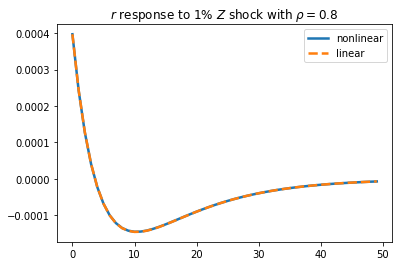

In [44]:
dr_nonlin = td_nonlin['r'] - ss['r']
dr_lin = G['r'] @ (Z - ss['Z'])
plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'$r$ response to 1% $Z$ shock with $\rho=0.8$')
plt.legend()
plt.show()

There is no visible difference -- the first-order approximation is almost perfect here.

If we increase the size of the productivity shock on impact to 10% (enormous!), we can begin to see small nonlinearities kick in, and the solution requires five iterations rather than three:

Max error 3.47E-01 on iteration 0
Max error 5.17E-03 on iteration 1
Max error 1.15E-04 on iteration 2
Max error 1.69E-06 on iteration 3
Max error 1.17E-08 on iteration 4
Max error 2.91E-10 on iteration 5


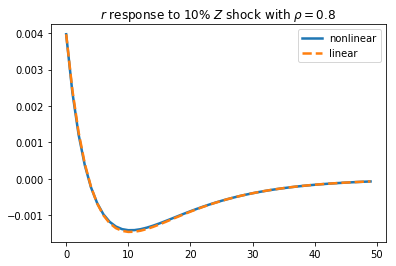

In [45]:
Z = ss['Z'] + 0.1*0.8**np.arange(T)
td_nonlin = td_nonlinear(ss, H_K_inv, Z)
dr_nonlin = td_nonlin['r'] - ss['r']
dr_lin = G['r'] @ (Z - ss['Z'])
plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'$r$ response to 10% $Z$ shock with $\rho=0.8$')
plt.legend()
plt.show()